# Optical simulation of vacuum tube collector array

## Structure of this document
1. Fragments of the simulation code
2. Visualization of parts of the system
3. Visualization and simulation of a single collector
  1. Cylindrical collector
  2. Shifted cylindrical collector
  3. Dual cylindrical collector
  4. Parabolic collector


## Known limitations

* We ignore light polarization in this simulation
* We use constant reflectivity along the surface (although there is work-in progress to introduce this feature in our free time)

## Notes on code
* We provide reasonable amounts of hopefully, self-explanatory code from which follows how we define our system and which parameters can be tweaked.
* We use customized discontinued open-source engine (PyOptTools) of which we maintain a branch


In [1]:
from pyoptools.all import *
import numpy as np
import math

import sys
sys.stdout = open('/dev/stdout', 'w')

Loading component library Edmund  from files  ['/home/faxik/workspace-private/pyoptools/pyoptools/raytrace/library/Edmund/SphOptics1.cmp', '/home/faxik/workspace-private/pyoptools/pyoptools/raytrace/library/Edmund/SphOptics.cmp']


# Components

## Vacuum tube

Vacuum tubes are thermos-like glass structure which can be represented as two concentric glass tubes in cross-section. Absorbing filament can be either on the inner tube surface, or be fully inside inner tube. The former are more efficient.

We use more efficient ones which are modelled as two independent glass tubes, one inside the other, with absorbing filament over the inner tube. Technical data about the tubes is taken from supplier specs.


### Code

In [2]:
TUBE_REFLECTIVITY         = .075/2
FILAMENT_REFLECTIVITY     = .063

# Bohr-silicate glass
GLASS_ABSORPTION          = .018/2
GLASS_N                   = 1.472

TUBE_EXTERNAL_GLASS_WIDTH = 1.525 #1.8
TUBE_INTERNAL_GLASS_WIDTH = 1.525 #1.6
TUBE_EXTERNAL_DIAMETER    = 58
TUBE_INTERNAL_DIAMETER    = 47

class Tube(System):
    def __init__(self, absorberOnInner=True, *args, **kwargs):
        self.outer    = self.tube(TUBE_EXTERNAL_DIAMETER, TUBE_EXTERNAL_GLASS_WIDTH, 
                                  color=[.7,.7,1,.4], material=GLASS_N)
        complist      = [(self.outer, (0,0,0),(0,0,0))]
        
        if absorberOnInner:
            self.absorber = self.filament(TUBE_INTERNAL_DIAMETER, color=[.1,.1,.1,1])
        else:
            self.inner    = self.tube(TUBE_INTERNAL_DIAMETER, TUBE_INTERNAL_GLASS_WIDTH, 
                                      color=[.7,.7,1,.4], material=GLASS_N)
            self.absorber = self.filament(TUBE_INTERNAL_DIAMETER-2*TUBE_INTERNAL_GLASS_WIDTH-.1, 
                                          color=[.1,.1,.1,1])
            complist.append( (self.inner, (0,0,0),(0,0,0)) )
                         
        complist.append((self.absorber, (0,0,0),(0,0,0)))
        
        System.__init__(self, complist=complist, n=1., *args, **kwargs)
    
    def tube(self, diameter, width, color, material, length=100):
        S1=Cylinder(radius=diameter/2,      length=length, color=color, 
                    reflectivity=TUBE_REFLECTIVITY, absorption=GLASS_ABSORPTION)
        S2=Cylinder(radius=diameter/2-width,length=length, color=color, 
                    reflectivity=TUBE_REFLECTIVITY, absorption=GLASS_ABSORPTION)
        return Component(surflist=[(S1,(0,0,0),(0,0,0)), (S2,(0,0,0),(0,0,0))],material=material)

    def filament(self, diameter, color, length = 100):
        S = Cylinder(radius = diameter/2, color=color, length=length,
                     reflectivity=FILAMENT_REFLECTIVITY, absorption=1-FILAMENT_REFLECTIVITY)
        # TODO: Add caps
        return Component(surflist=[(S,(0,0,0),(0,0,0))], material=1.)
    
    def absorbed(self):
        return ray_power( [t[1] for t in self.absorber.hit_list] )
        
    
    
class Reflector(Component):
    
    def __init__(self, diameter, *args, **kwargs):
        Component.__init__(self, surflist=[(Cylindrical(curvature = 2/diameter, 
                                                        shape=Rectangular(size=(diameter,100)),
                                                        color=[1,1,1,1],
                                                        reflectivity=.92
                                                       ),
                                           (0,diameter/2,0), (pi/2,0,0))])
        
def ray_power(rays):
    return sum( [r.intensity for r in rays] )

def create_rays(N, start, step, angle=0):
   return [Ray(pos=np.array(start)+i*np.array((step/math.cos(angle),0,0)),
               dir=(math.sin(angle), math.cos(angle), 0)) for i in range(N)]



## Visualization

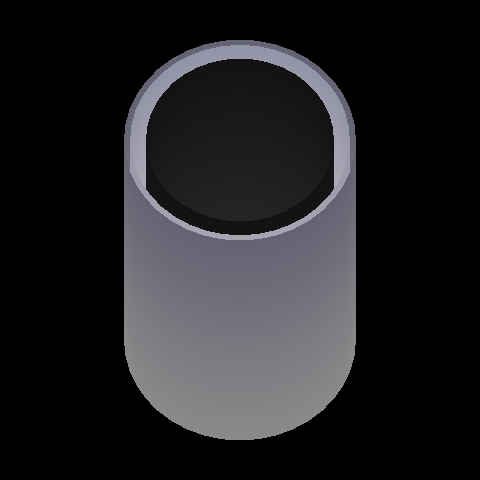

In [3]:
St = Tube()
Plot3D(St,size=(120,120),scale=4,rot=[(pi/6,0,0)])


# Simulation

##Without Reflector

We measure total energy that is delivered to the filament. Rays are cut-off when energy falls below 0.1% of the incident energy.

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars


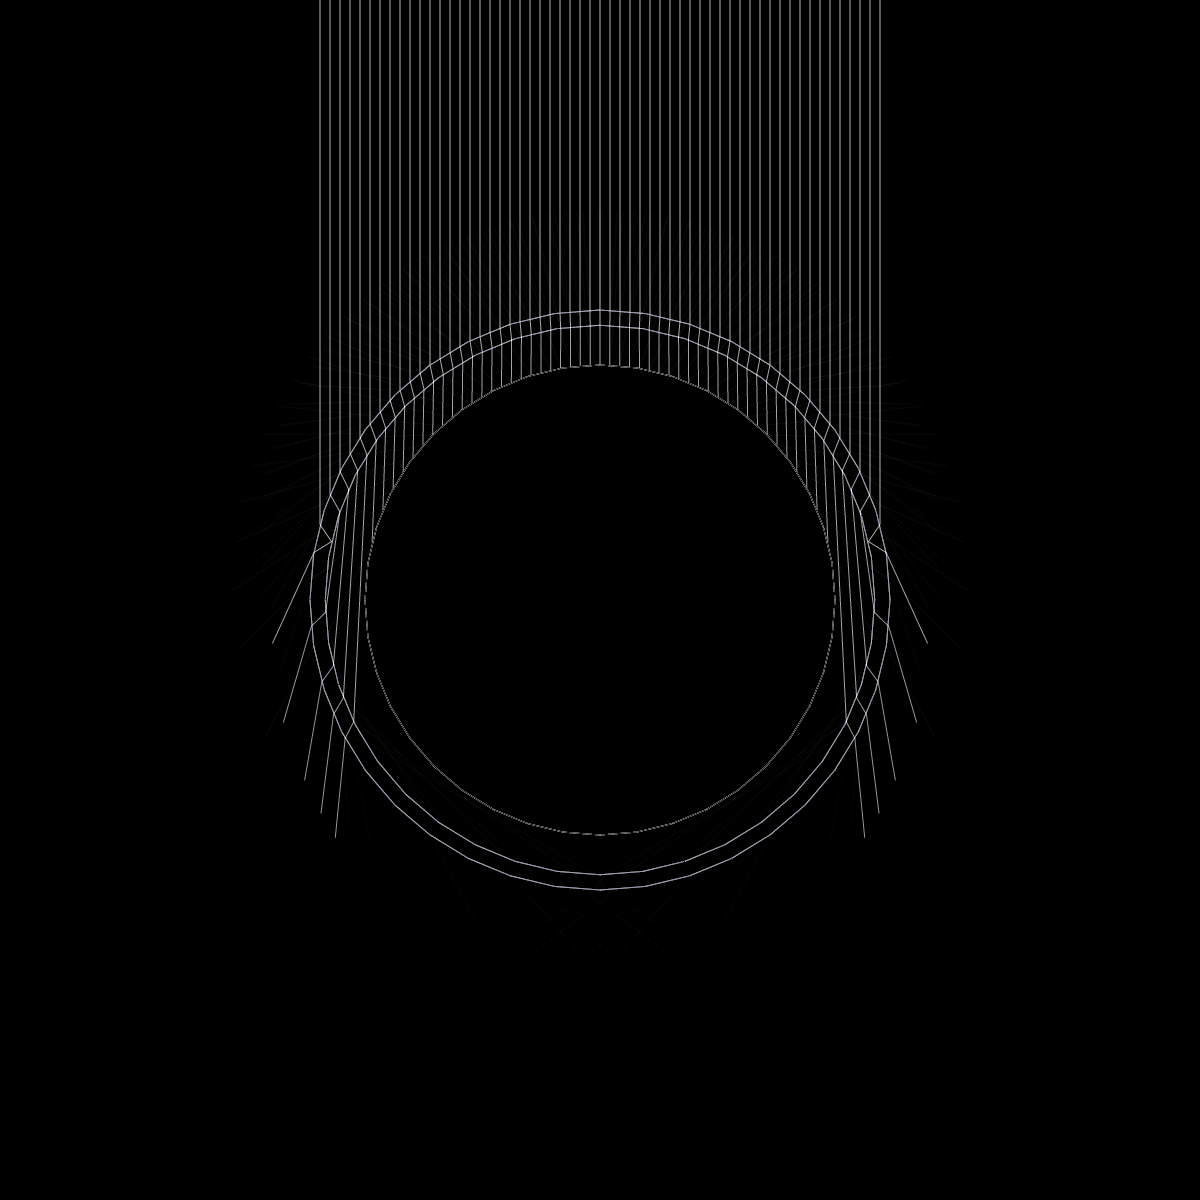

In [7]:
St = Tube()
rays = create_rays(int(160/RAY_STEP), start=(-80,-100,0), step=RAY_STEP)
St.ray_add(rays)
St.propagate()

Plot3D(St,size=(120,120),scale=10,rot=[(0.0,0,0)], wireframe=True)

In [8]:
POWER_WITHOUT_REFLECTOR = St.absorbed()
POWER_WITHOUT_REFLECTOR

42.98344772804285

In [9]:
INCIDENT_POWER = ray_power([r[1] for r in St.outer.hit_list if r[1].orig_surf is None])
INCIDENT_POWER

57.0

### Efficiency of a tube

In [10]:
POWER_WITHOUT_REFLECTOR / INCIDENT_POWER

0.7540955741761903

*Note* This is efficiency in zenith; when the collector is at angle, efficiency improves, to a certain limit when tubes start covering the problematic areas.

# Multitube systems

Because of their shape, vacuum tubes are extremely efficient on the angles $[-45;45]$ degrees and above. The main function of the reflector in this settings is not to shade reflected rays between the tubes.

In [22]:
def tube_array(N, step):
    return System(complist=[(Tube(), ((i-(N-1)/2)*step,0, 0),(0,0,0)) for i in range(N)])

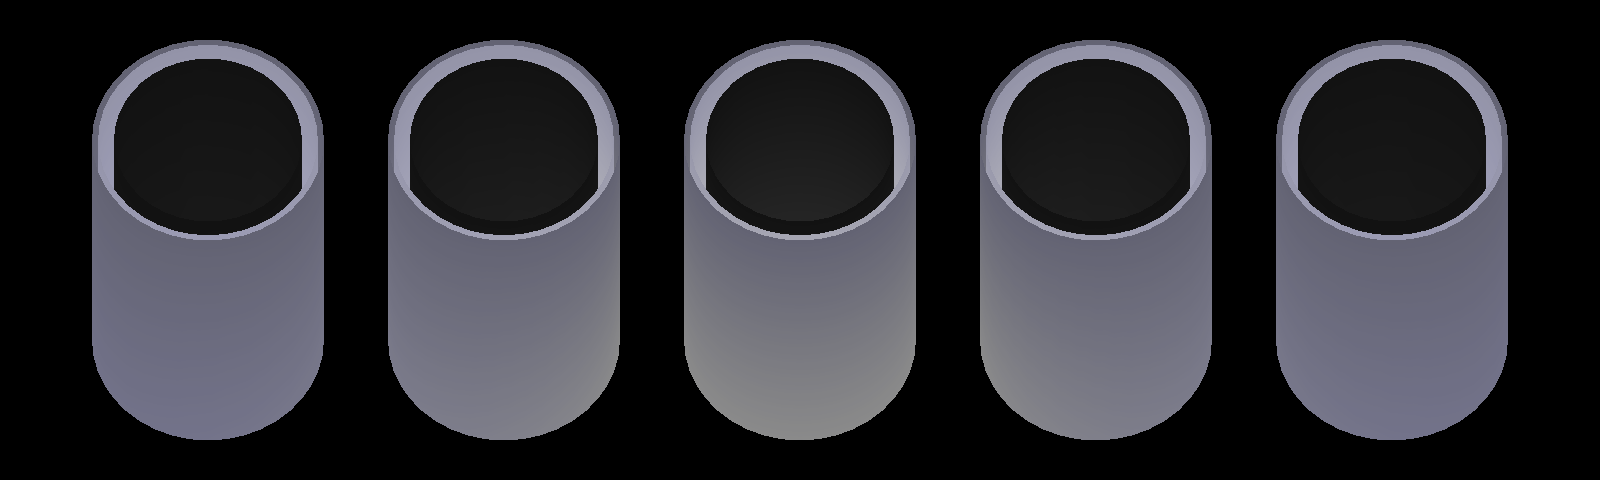

In [23]:
S = tube_array(5, 74)
Plot3D(S,size=(400,120),scale=4,rot=[(pi/6,0,0)])

### Simulation of incident rays at $45^\circ$

In [24]:
ANGLE = pi/4
#rays = create_rays(int(1000/RAY_STEP), angle=pi/4, start=(-400,-100,0), step=RAY_STEP)
rays = create_rays(int(1000/RAY_STEP), angle=ANGLE, start=(-74*3-100*np.sin(ANGLE),-100*np.cos(ANGLE),0), step=RAY_STEP)
S.ray_add(rays)
S.propagate()

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


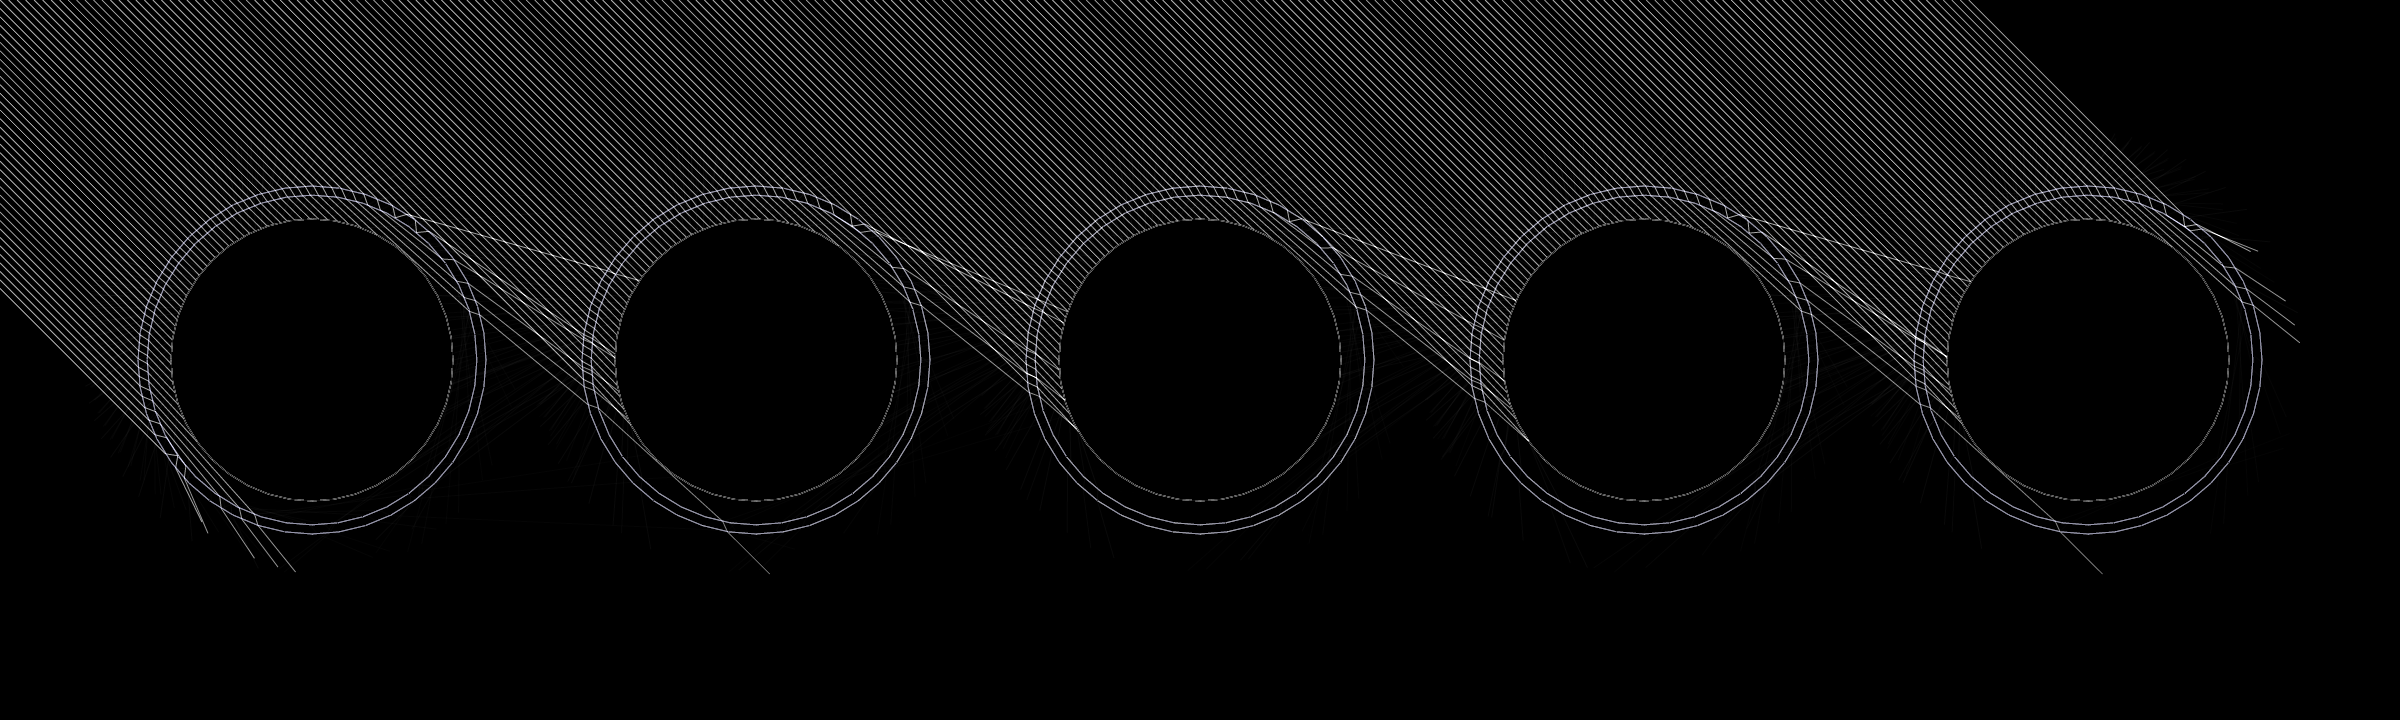

In [25]:
Plot3D(S,size=(400,120),scale=6,rot=[(0.0,0,0)], wireframe=True)

In [26]:
total_absorbed = [a[0].absorbed() for a in S.complist]
#total_absorbed

In [27]:
efficiency = sum(total_absorbed) / (57 * 5)
efficiency

0.8298574844501154

In [57]:
def simulate_rays(angle, sys_creation_fn, tubes=5):
    S = sys_creation_fn(tubes, 74)
    rays = create_rays(int(1000/RAY_STEP), angle=angle, start=(-74*tubes/2.-400*np.sin(angle),-400*np.cos(angle),0), step=RAY_STEP)
    S.ray_add(rays)
    S.propagate()
    total_absorbed = [a[0].absorbed() for a in S.complist if hasattr(a[0], 'absorbed')]
    return sum(total_absorbed)

In [58]:
angles = np.linspace(-89, 89, 179)

In [59]:
powers_tube_20 = [simulate_rays( angle, tube_array, 20) for angle in np.deg2rad( angles )]
#powers_tube
    

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


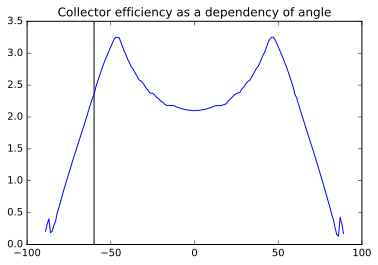

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
eff1 = plt.plot(angles,np.array(powers_tube_20)/(57*5))
plt.title('Collector efficiency as a dependency of angle')
plt.vlines( -60, ymin=0, ymax=3.5 )
eff1

In [75]:
import pandas as pd
powers_20 = pd.DataFrame( index=angles, data={ 'absorbed': powers_tube_20 } )
powers_20

absorbed
-89.0   59.829634
-88.0   91.231825
-87.0  114.837269
-86.0   52.702811
-85.0   59.765739
-84.0   85.156177
-83.0  104.382879
-82.0  140.705924
-81.0  165.292696
-80.0  192.792260
-79.0  219.572557
-78.0  246.091084
-77.0  270.922251
-76.0  295.010020
-75.0  319.946893
-74.0  343.308049
-73.0  369.290179
-72.0  392.775716
-71.0  416.353705
-70.0  440.476442
-69.0  464.211137
-68.0  486.761574
-67.0  509.784168
-66.0  531.813940
-65.0  557.193272
-64.0  580.721862
-63.0  606.694400
-62.0  630.358847
-61.0  653.647185
-60.0  669.174165
...           ...
 60.0  670.605475
 61.0  655.784245
 62.0  629.502616
 63.0  605.347422
 64.0  582.223831
 65.0  556.312609
 66.0  533.486327
 67.0  509.954541
 68.0  486.968755
 69.0  464.407203
 70.0  440.714451
 71.0  417.054221
 72.0  393.339103
 73.0  368.359538
 74.0  343.969430
 75.0  318.080232
 76.0  293.738847
 77.0  268.710039
 78.0  242.003963
 79.0  216.086539
 80.0  189.708121
 81.0  163.143336
 82.0  133.270710
 83.0  110.351059
 84.0   74.041546
 85.0   44.472965
 86.0   37.793139
 87.0  122.310099
 88.0   92.068599
 89.0   49.696553

[179 rows x 1 columns]

In [81]:
powers_20.to_csv('powers20.csv')

In [63]:
def tube_array_r(N, step):
    return System(complist=[(Tube(), ((i-(N-1)/2)*step,0, 0),(0,0,0)) for i in range(N)] +
                  [(Reflector(73.7), ((i-(N-1)/2)*step,-4,0), (0,0,0)) for i in range(N)]
                  )
                 


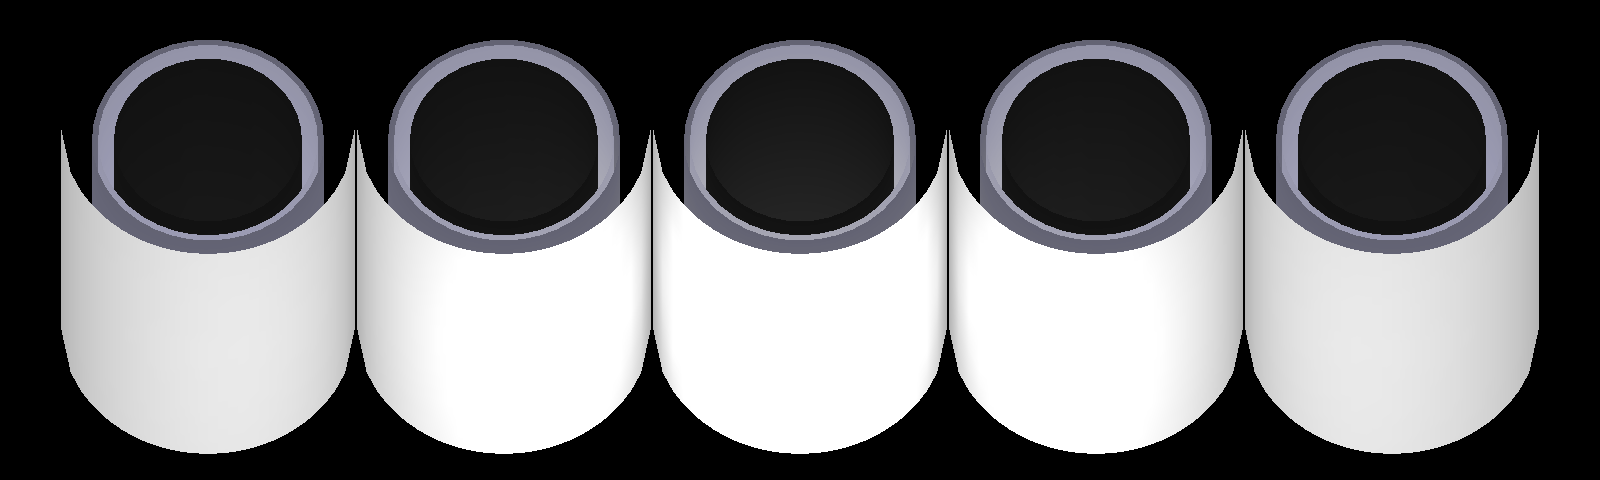

In [64]:
S = tube_array_r(5, 74)
Plot3D(S,size=(400,120),scale=4,rot=[(pi/6,0,0)])

In [65]:
ANGLE = pi/4
#rays = create_rays(int(1000/RAY_STEP), angle=pi/4, start=(-400,-100,0), step=RAY_STEP)
rays = create_rays(int(1000/RAY_STEP), angle=ANGLE, start=(-74*3-100*np.sin(ANGLE),-100*np.cos(ANGLE),0), step=RAY_STEP)
S.ray_add(rays)
S.propagate()

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


/usr/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


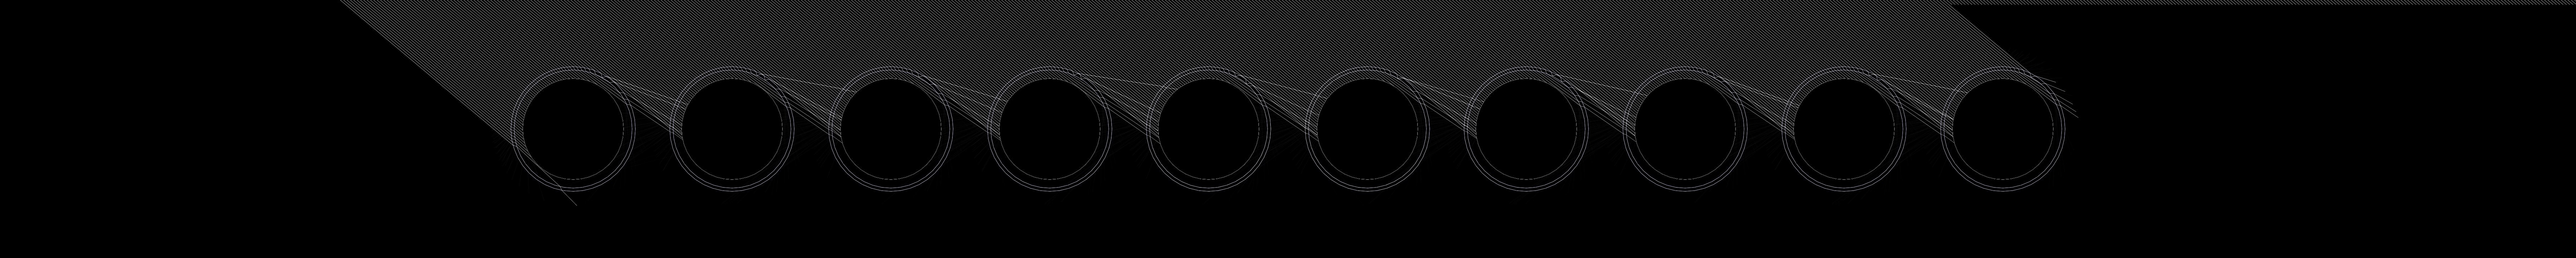

In [80]:
ANGLE = np.deg2rad( 0 )
TUBES = 10
S = tube_array( TUBES, 74)

#rays = create_rays(int(1000/RAY_STEP), angle=pi/4, start=(-400,-100,0), step=RAY_STEP)
rays = create_rays(int(TUBES*74/RAY_STEP), angle=ANGLE, start=(-74*TUBES/2.-100*np.sin(ANGLE),-100*np.cos(ANGLE),0), step=RAY_STEP)
S.ray_add(rays)
S.propagate()

Plot3D(S,size=(1200,120),scale=6,rot=[(0.0,0,0)], wireframe=True)

# Efficiency calculation for arbitrary vector

Suppose, the sun is at $R=(x_1, y_1, z_1)$ and collector normal is at $\hat{n}=(x_2, y_2, z_2)$.

In tube collector, there are 2 components which have different response:
- Along tubes
- perpendicular to them

In the flat collector, we can just use $R\cdot\hat{n}$ to estimate its efficiency.

In tube collector we have to decompose the vector and then multiply the components
1. $\cos(\alpha)$ in longitudal direction
2. response curve (as function of $\cos(\beta)$) in latitudal direction

## Test

Test that the complex formula with the linear response curve gives the same result as simpler normal-multiplication formula
